In [8]:
import os, sys
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))

# data_helper

## 源代码

In [12]:

import numpy as np
import re
from sklearn.datasets import fetch_20newsgroups
from sklearn.datasets import load_files
import yaml

with open(r"D:\lauyu\work\FeiMedia\text_classification\cnn-text-classification-tf\config.yml", 'r') as ymlfile:
    cfg = yaml.load(ymlfile)
dataset_name = cfg["datasets"]["default"]


def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()


def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]


def get_datasets_20newsgroup(subset='train', categories=None, shuffle=True, random_state=42):
    """
    Retrieve data from 20 newsgroups
    :param subset: train, test or all
    :param categories: List of newsgroup name
    :param shuffle: shuffle the list or not
    :param random_state: seed integer to shuffle the dataset
    :return: data and labels of the newsgroup
    """
    datasets = fetch_20newsgroups(subset=subset, categories=categories, shuffle=shuffle, random_state=random_state)
    return datasets


def get_datasets_mrpolarity(positive_data_file, negative_data_file):
    """
    Loads MR polarity data from files, splits the data into words and generates labels.
    Returns split sentences and labels.
    """
    # Load data from files
    positive_examples = list(open(positive_data_file, "r", encoding='latin-1').readlines())
    positive_examples = [s.strip() for s in positive_examples]
    negative_examples = list(open(negative_data_file, "r", encoding='latin-1').readlines())
    negative_examples = [s.strip() for s in negative_examples]

    datasets = dict()
    datasets['data'] = positive_examples + negative_examples
    target = [0 for _ in positive_examples] + [1 for _ in negative_examples]
    datasets['target'] = target
    datasets['target_names'] = ['positive_examples', 'negative_examples']
    return datasets


def get_datasets_localdata(container_path=None, categories=None, load_content=True,
                       encoding='latin-1', shuffle=True, random_state=42):
    """
    Load text files with categories as subfolder names.
    Individual samples are assumed to be files stored a two levels folder structure.
    :param container_path: The path of the container
    :param categories: List of classes to choose, all classes are chosen by default (if empty or omitted)
    :param shuffle: shuffle the list or not
    :param random_state: seed integer to shuffle the dataset
    :return: data and labels of the dataset
    """
    datasets = load_files(container_path=container_path, categories=categories,
                          load_content=load_content, shuffle=shuffle, encoding=encoding,
                          random_state=random_state)
    return datasets


def load_data_labels(datasets):
    """
    Load data and labels
    :param datasets:
    :return:
    """
    # Split by words
    x_text = datasets['data']
    if dataset_name != "localdata":
        x_text = [clean_str(sent) for sent in x_text]
    # Generate labels
    labels = []
    for i in range(len(x_text)):
        label = [0 for _ in datasets['target_names']]
        label[datasets['target'][i]] = 1
        labels.append(label)
    y = np.array(labels)
    return [x_text, y]


def load_embedding_vectors_word2vec(vocabulary, filename, binary):
    # load embedding_vectors from the word2vec
    encoding = 'utf-8'
    with open(filename, "rb") as f:
        header = f.readline()
        vocab_size, vector_size = map(int, header.split())
        # initial matrix with random uniform
        embedding_vectors = np.random.uniform(-0.25, 0.25, (len(vocabulary), vector_size))
        if binary:
            binary_len = np.dtype('float32').itemsize * vector_size
            for line_no in range(vocab_size):
                word = []
                while True:
                    ch = f.read(1)
                    if ch == b' ':
                        break
                    if ch == b'':
                        raise EOFError("unexpected end of input; is count incorrect or file otherwise damaged?")
                    if ch != b'\n':
                        word.append(ch)
                word = str(b''.join(word), encoding=encoding, errors='strict')
                idx = vocabulary.get(word)
                if idx != 0:
                    embedding_vectors[idx] = np.fromstring(f.read(binary_len), dtype='float32')
                else:
                    f.seek(binary_len, 1)
        else:
            for line_no in range(vocab_size):
                line = f.readline()
                if line == b'':
                    raise EOFError("unexpected end of input; is count incorrect or file otherwise damaged?")
                parts = str(line.rstrip(), encoding=encoding, errors='strict').split(" ")
                if len(parts) != vector_size + 1:
                    raise ValueError("invalid vector on line %s (is this really the text format?)" % (line_no))
                word, vector = parts[0], list(map('float32', parts[1:]))
                idx = vocabulary.get(word)
                if idx != 0:
                    embedding_vectors[idx] = vector
        f.close()
        return embedding_vectors


def load_embedding_vectors_glove(vocabulary, filename, vector_size):
    # load embedding_vectors from the glove
    # initial matrix with random uniform
    embedding_vectors = np.random.uniform(-0.25, 0.25, (len(vocabulary), vector_size))
    f = open(filename)
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        idx = vocabulary.get(word)
        if idx != 0:
            embedding_vectors[idx] = vector
    f.close()
    return embedding_vectors

In [15]:
datasets = get_datasets_localdata(container_path=r'D:\lauyu\work\FeiMedia\text_classification\cnn-text-classification-tf\data\id_data',
                                                     categories=cfg["datasets"][dataset_name]["categories"],
                                                     shuffle=cfg["datasets"][dataset_name]["shuffle"],
                                                     random_state=cfg["datasets"][dataset_name]["random_state"])
x_text, y = load_data_labels(datasets)

In [21]:
datasets.target[:10]

array([3, 3, 2, 2, 2, 2, 2, 2, 3, 2])

In [24]:
datasets.target_names

['BodyCare', 'Fashion', 'make_up', 'skin_care']

In [25]:
x_text = datasets['data']
if dataset_name != "localdata":
    x_text = [clean_str(sent) for sent in x_text]
# Generate labels
labels = []
for i in range(len(x_text)):
    label = [0 for _ in datasets['target_names']]
    label[datasets['target'][i]] = 1
    labels.append(label)
y = np.array(labels)

In [31]:
from tensorflow.contrib import learn
max_document_length = max([len(x.split(" ")) for x in x_text])
vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length)
x = np.array(list(vocab_processor.fit_transform(x_text)))

D:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [38]:
x_text[1]

'serum seaweed yang bisa jadi primer plus pelembab dari wardah beli wardah nature daily primary skin hydrating booster ini karena kena rayuan dari beauty advisor di guardian kebetulan memang pelembab wajah gue itu udah abis jadi gue kepikiran untuk beli nih karena ada kandungan hydraboost formula dan hyaluronic acid yang ngebuat kulit gue jadi lembut dan lembab terus ada kandungan seaweednya yang ngebantu menjaga kulit wajah gue biar ga terlalu kering ataupun terlalu oily gue beli sekitar dua bulan lalu harganya di bawah 50ribu masih tetep gue pake sampe sekarang karena gue udah terlanjur suka sama produk ini gue baru sadar sebenernya produk ini bukan hanya sekadar pelembab biasa tapi hydrating booster which is ini ngasih benefit lebih banyak dari pelembab biasa untuk membuat kulit gue lebih kenyal dan sehat uniknya finish dari pemakaian produk ini sticky gitu so i think it will be good to be my primer why not muka gue jadi lembab plus makeup gue jadi tahan lama kann texture nya agak k

In [39]:
import math

max_learning_rate = 0.005
min_learning_rate = 0.0001
decay_speed = 5
counter = 0
x = list(range(20000))
y = []
for i in x:
    learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-i/decay_speed)
    y.append(learning_rate)

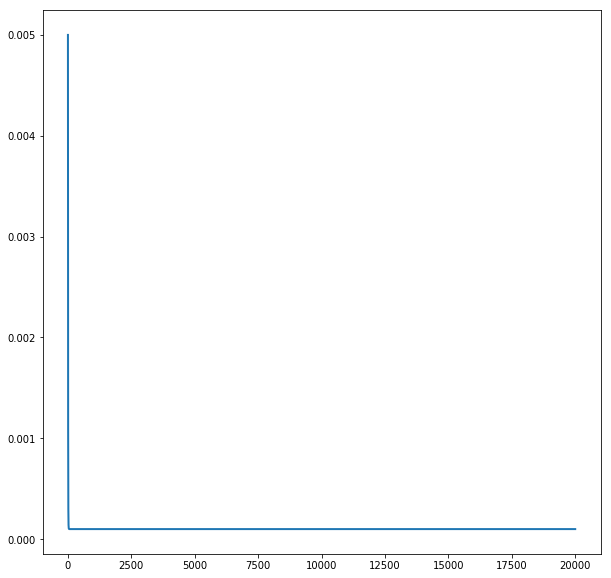

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.plot(x, y, linewidth=2)
plt.show()